In [ ]:
using QuantumAnnealingTools
# This package is needed to load actual ODE solvers. Without it, the ODE solvers won't work.
using DifferentialEquations
# We need to plot our results for the demo
using Plots
# SpecialFuntions package is need for erf function
using SpecialFunctions

# Single Qubit Oscillation

In this example, we will try to recreate the single qubit interference example in [reference](https://arxiv.org/abs/1903.00574). We will work with ideal qubit model (instead of the circuit itself).

## Schedules and Adiabatic Frame Representation
Assume, in the Schrodinger picture, the Hamiltonian has the form of
\begin{equation}
    H = -\frac{1}{2}E_0[A(s)Z+B(s)Y]
\end{equation}
We can reparametrize the annealing schedules $A(s)$ and $B(s)$ in terms of gap $\Delta(s)$ and annealing angle $\theta(s)$, where
\begin{equation}
A(s) = \Omega(s) \cos\theta(s) \quad B(s) = \Omega(s) \sin\theta(s) \quad \Delta(s) = E_0\Omega(s)
\end{equation}
In the reference paper, we use a double Gaussian annealing angle
\begin{equation}
\frac{\mathrm{d}\theta}{\mathrm{d}\tau} = \frac{\alpha\sqrt{\pi}}{4}\bigg\{e^{-[\alpha(\tau-(\tau_f/2+\mu))]^2} + e^{-[\alpha(\tau-(\tau_f/2-\mu))]^2} \bigg\}
\end{equation}
where
\begin{equation}
\tau(s) = \int_0^s \mathrm{s}' \Omega(s')
\end{equation}
In the following block, we define those quantites for some specific choice of parameters

In [2]:
const α=32
const μ=1/6
const e0=0.25
const τf = 3/4

function Ω(s)
    (1.0 + cos(pi*s)^2)/2.0
end

function τ(s)
    (6*pi*s+sin(2*pi*s))/8/pi
end

function θ(s)
    x = τ(s)
    pi*(2+erf(α*(x-τf/2-μ))+erf(α*(x-τf/2+μ)))/8
end

# the function dθ here is dθ/dτ(s) in the paper
function dθ(s)
    x = τ(s)
    α*sqrt(pi)*(exp(-(α*(x-τf/2-μ))^2)+exp(-(α*(x-τf/2+μ))^2))/4
end

function Δ(s)
    e0 * Ω(s)
end;

First we plot the double gaussian schedule

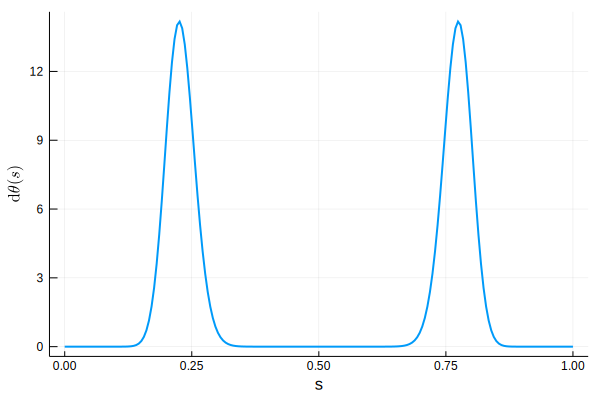

In [3]:
s_axis = range(0, 1, length=200)
dtheta = [dθ(s) for s in s_axis]
plot(s_axis, dtheta, linewidth=2, label="")
xlabel!("s")
ylabel!(L"\mathrm{d}\theta(s)")

Then we plot the gap $\Delta(s)$. In this example, we choose a gap of the following form
\begin{equation}
    \Delta(s) = \frac{E_0}{2}\big( 1+\cos(\pi s)^2 \big)
\end{equation}

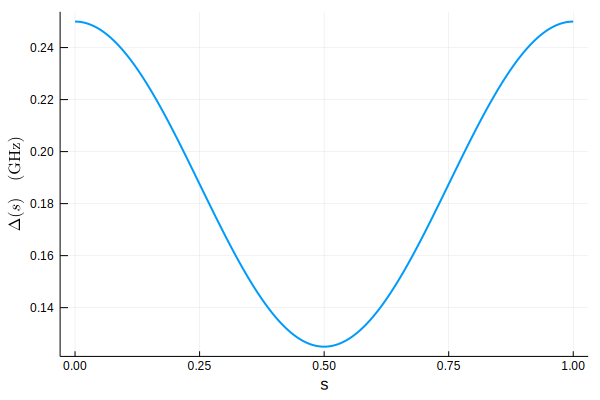

In [4]:
s_axis = range(0, 1, length=200)
Delta = [Δ(s) for s in s_axis]
plot(s_axis, Delta, linewidth=2, label="")
xlabel!("s")
ylabel!(L"\Delta(s) \quad (\mathrm{GHz})")

We can also convert the gap and angle representation back to the standard $A(s)$ and $B(s)$ schedules

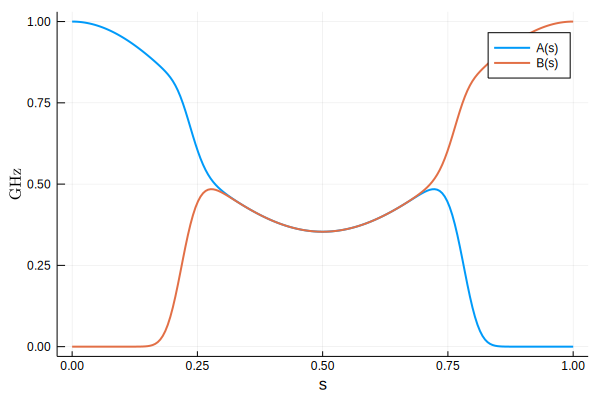

In [5]:
s_axis = range(0, 1, length=200)
A = [Ω(s)*cos(θ(s)) for s in s_axis]
B = [Ω(s)*sin(θ(s)) for s in s_axis]
plot(s_axis, A, linewidth=2, label="A(s)")
plot!(s_axis, B, linewidth=2, label="B(s)")
xlabel!("s")
ylabel!(L"\mathrm{GHz}")

## Open System Simulation
We can either solve the Redfield equation in the Schrodinger picture or in the adiabtic frame. 
### Schrodinger Picture
First, we illustrate how to do it in the Schrodinger picture.

In [6]:
# first we interpolate the schedule to create callable object
Af = construct_interpolations(s_axis, -0.5*e0*A; extrapolation = "line")
Bf = construct_interpolations(s_axis, -0.5*e0*B; extrapolation = "line")
# then we construct the Hamiltonian
H = DenseHamiltonian([Af, Bf], [σz, σy])
# we construct the initial state
u0 = PauliVec[3][1]
# and system bath coupling
coupling = ConstantCouplings(["Z"], unit=:ħ)
bath = Ohmic(1e-4, 4, 16);

In [7]:
# Now we construct the annealing object
annealing = Annealing(H, u0; coupling=coupling, bath=bath)

Annealing with hType DenseHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0: Complex{Float64}[1.0 + 0.0im, 0.0 + 0.0im]
bath: OhmicBath(0.0001, 25.132741228718345, 0.4773896944364562)

Now we solve the Redfield equation for various $t_f$ values and plot the final ground state probabilities.

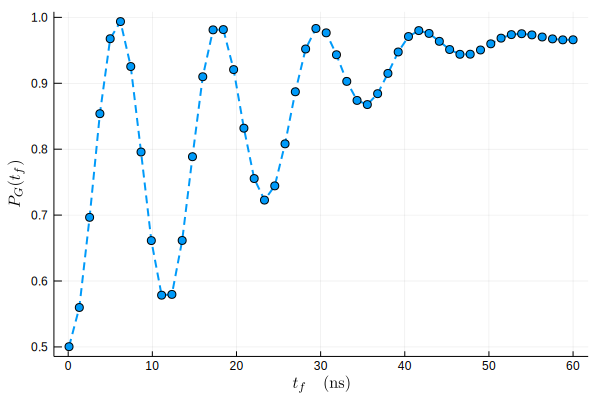

In [8]:
tf_list = range(0.1, 60, length=50)
y = []
# to solve the Redfield equation, we solve the unitary evolution first
for tf in tf_list
    U = solve_unitary(annealing, tf; abstol=1e-6, reltol=1e-6)
    redfield_sol = solve_redfield(annealing, tf, U; abstol=1e-6, reltol=1e-6)
    # this line of code calculate the final ground state population
    push!(y, real(PauliVec[2][1]' * redfield_sol[end] * PauliVec[2][1]))
end
plot(tf_list, y, marker=:c, linestyle=:dash, linewidth=2, label="")
xlabel!(L"t_f \quad (\mathrm{ns})")
ylabel!(L"P_G(t_f)")

### Adiabatic Frame
Next, we can do this directly in the adiabatic frame. In this case, we need to create an `AdiabaticFrameHamiltonian` object. This object can be created by specifying the frequencies of each level and the corresponding geometric phase. Additionally, the system bath coupling term becomes time dependent in the adiabatic frame.

In [62]:
# ωfuns is a list of the frequencies of each levels
ωfuns = [(s)->-0.5*Δ(s), (s)->0.5*Δ(s)]
# geofuns is a list of the geometric phase. The corresponding index is [(1,2), (1,3)...(2,3)...]
geofuns = [(s)->0.5*dθ(s)*Ω(s)]
H = AdiabaticFrameHamiltonian(ωfuns, geofuns)
u0 = PauliVec[3][1]
# construct system bath coupling
c = TimeDependentCoupling([(s)->cos(θ(s)), (s)->sin(θ(s))], [σy, σz], unit=:ħ)
coupling = TimeDependentCouplings(c)
bath = Ohmic(1e-4, 4, 16)
# Now we construct the annealing object
annealing = Annealing(H, u0; coupling=coupling, bath=bath)

Annealing with hType AdiabaticFrameHamiltonian{Complex{Float64}} and uType Array{Complex{Float64},1}
s parameter span: (0.0, 1.0)
u0: Complex{Float64}[1.0 + 0.0im, 0.0 + 0.0im]
bath: OhmicBath(0.0001, 25.132741228718345, 0.4773896944364562)

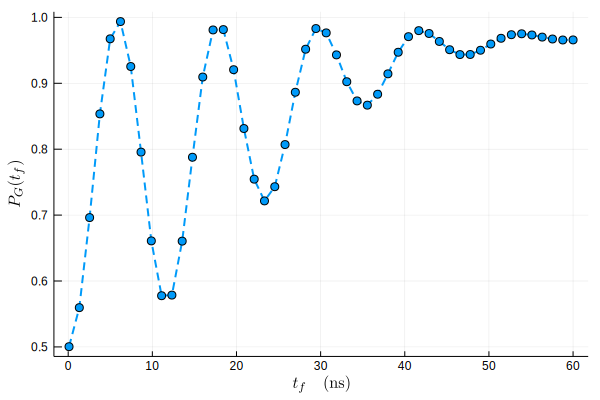

In [63]:
tf_list = range(0.1, 60, length=50)
y = []
# to solve the Redfield equation, we solve the unitary evolution first
for tf in tf_list
    U = solve_unitary(annealing, tf; abstol=1e-6, reltol=1e-6)
    redfield_sol = solve_redfield(annealing, tf, U; abstol=1e-6, reltol=1e-6);
    push!(y, real(redfield_sol[end][1,1]))
end
plot(tf_list, y, marker=:c, linestyle=:dash, linewidth=2, label="")
xlabel!(L"t_f \quad (\mathrm{ns})")
ylabel!(L"P_G(t_f)")

This produce the same results as in Schrodinger picture.